In [1]:
import pandas as pd
import numpy as np
import iris
import xarray as xr
from cartopy import crs as ccrs
from sklearn.neighbors import NearestNeighbors
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from collections import OrderedDict

def get_orography():
    alt = iris.load('../netcdf/surface_altitude.nc')[0]
    
    gradx, grady = alt.copy(), alt.copy()
    gradx.data = np.gradient(alt.data)[1]
    grady.data = np.gradient(alt.data)[0]
    
    slope = alt.copy()
    slope.data = np.sqrt(np.square(gradx.data) + np.square(grady.data))
    
    face = alt.copy()
    face.data = np.arctan2(grady.data, gradx.data)
    return OrderedDict([('alt', alt), ('gradx', gradx), ('grady', grady), ('slope', slope), ('face', face)])

In [3]:
def add_orog_pd(df):
    alt, gradx, grady, slope, face = get_orography().values()
    
    ref = np.array(list(product(alt.coord('grid_longitude').points - 360, alt.coord('grid_latitude').points)))

    coords = alt.coord_system().as_cartopy_crs().transform_points(ccrs.PlateCarree(), 
                                                                  df['longitude'].values, 
                                                                  df['latitude'].values)[:,:2]

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(ref)

    inds = nbrs.kneighbors(coords, return_distance=False).flatten()
    inds2 = np.array([-(inds % alt.coord('grid_latitude').points.shape), 
                     inds // alt.coord('grid_latitude').points.shape]).T
    
    alts = alt.data[inds2[:,0], inds2[:,1]]
    slopes = slope.data[inds2[:,0], inds2[:,1]]
    faces = face.data[inds2[:,0], inds2[:,1]]
    
    df['surface_altitude'] = alts
    df['slope'] = slopes
    df['face'] = faces
    df['grid_lat'] = coords[:,1]
    df['grid_lon'] = coords[:,0]

In [16]:
def add_orog_xr(df):
    alt, gradx, grady, slope, face = get_orography().values()
    
    coords = alt.coord_system().as_cartopy_crs().transform_points(ccrs.PlateCarree(), 
                                                                  df['longitude'].values, 
                                                                  df['latitude'].values)[:,:2]
    print(alt)
    
    df['surface_altitude'] = xr.DataArray(np.tile(alt[1:-1,1:-1].data.flatten(), 187))
    df['slope'] = xr.DataArray(np.tile(slope[1:-1,1:-1].data.flatten(), 187))
    df['face'] = xr.DataArray(np.tile(face[1:-1,1:-1].data.flatten(), 187))
    df['grid_lat'] = xr.DataArray(coords[:,1])
    df['grid_lon'] = xr.DataArray(coords[:,0])

In [64]:
train2 = pd.read_csv('../data/train8.csv')

In [65]:
add_orog_pd(train2)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [66]:
train2.to_csv('../data/train8.new.csv')

In [30]:
test = pd.read_csv('../data/id_test8.csv')
test = test[test['fcst_id'] > 0]
# test = test.set_index(['fcst_id', 'latitude', 'longitude'], drop=True)
test = xr.Dataset(test)

In [31]:
add_orog_xr(test)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


surface_altitude / (m)              (grid_latitude: 50; grid_longitude: 421)
     Dimension coordinates:
          grid_latitude                           x                   -
          grid_longitude                          -                   x
     Scalar coordinates:
          forecast_period: 0.0 hours
          forecast_reference_time: 2016-08-01 03:00:00
          time: 2016-08-01 03:00:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s00i033
          source: Data from Met Office Unified Model
          um_version: 10.1


In [32]:
keep = ['DOY', 'air_temperature', 'distance', 'latitude', 'longitude', 'specific_humidity',
       'stratiform_rainfall_amount', 'stratiform_rainfall_amount_down', 
       'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right',
       'stratiform_rainfall_amount_up', 'surface_air_pressure', 'surface_altitude', 'target',
       'x_wind', 'y_wind', 'slope', 'face']

dvars = {k: (['fcst_id', 'grid_lat', 'grid_lon'], 
             v.data.reshape(187,48,419)) for k,v in test[keep].data_vars.items()}

y = xr.Dataset(dvars,
                 coords=dict([('fcst_id', np.unique(test['fcst_id'])), 
                          ('grid_lat', np.unique(test['grid_lat'].round(decimals=6))), 
                          ('grid_lon', np.unique(test['grid_lon'].round(decimals=6)))]),
                 )

In [33]:
y.to_netcdf('../data/id_test8.new.nc')

In [106]:
# y['surface_altitude'] = (['fcst_id', 'grid_lat', 'grid_lon'], 
#                          np.tile(get_orography()['alt'].data[1:-1, 1:-1], (187,1,1)))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [20]:
y

<xarray.Dataset>
Dimensions:                           (fcst_id: 187, grid_lat: 48, grid_lon: 419)
Coordinates:
  * fcst_id                           (fcst_id) float64 1.0 2.0 3.0 4.0 5.0 ...
  * grid_lat                          (grid_lat) float64 2.03 2.05 2.07 2.09 ...
  * grid_lon                          (grid_lon) float64 -5.079 -5.059 ...
Data variables:
    DOY                               (fcst_id, grid_lat, grid_lon) int64 167 ...
    air_temperature                   (fcst_id, grid_lat, grid_lon) float64 287.2 ...
    distance                          (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    latitude                          (fcst_id, grid_lat, grid_lon) float64 54.22 ...
    longitude                         (fcst_id, grid_lat, grid_lon) float64 -11.2 ...
    specific_humidity                 (fcst_id, grid_lat, grid_lon) float64 0.008545 ...
    stratiform_rainfall_amount        (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    stratiform_rainfall_amount_down   (

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


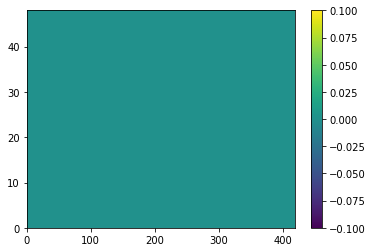

In [21]:
plt.pcolormesh((y['surface_altitude'][0] - get_orography()['alt'].data[1:-1, 1:-1]).data)
plt.colorbar()

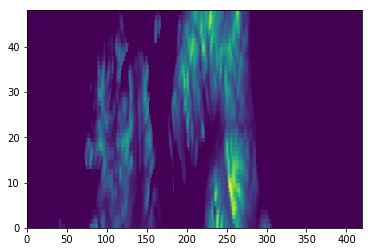

In [23]:
plt.pcolormesh(y['surface_altitude'][0])

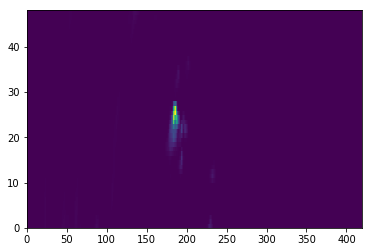

In [22]:
plt.pcolormesh(y['stratiform_rainfall_amount'][12])

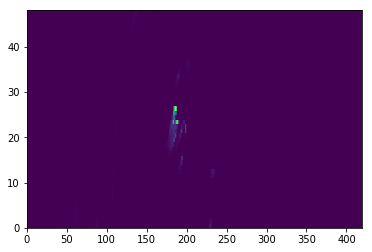

In [86]:
plt.pcolormesh(y['target'][12])

In [12]:
test['surface_altitude']

<xarray.DataArray 'surface_altitude' (dim_0: 3760944)>
array([   0.  ,    0.  ,    0.  , ...,  120.75,  110.5 ,  101.  ])
Coordinates:
  * dim_0      (dim_0) MultiIndex
  - fcst_id    (dim_0) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
  - latitude   (dim_0) float64 54.22 54.23 54.23 54.23 54.23 54.24 54.24 ...
  - longitude  (dim_0) float64 -11.2 -11.17 -11.14 -11.1 -11.07 -11.04 -11.0 ...

In [23]:
add_orog_xr(test)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


ValueError: cannot reindex or align along dimension 'dim_0' because the index has duplicate values

In [108]:
test.grid_lat

<xarray.DataArray 'grid_lat' (dim_0: 3760944)>
array([ 2.03005,  2.03005,  2.03005, ...,  2.97005,  2.97005,  2.97005])
Coordinates:
  * dim_0    (dim_0) int64 20112 20113 20114 20115 20116 20117 20118 20119 ...

In [107]:
test.set_index(grid_lat='grid_lat', grid_lon='grid_lon')

<xarray.Dataset>
Dimensions:                           (dim_0: 3760944, grid_lat: 3760944, grid_lon: 3760944)
Coordinates:
  * dim_0                             (dim_0) int64 20112 20113 20114 20115 ...
Dimensions without coordinates: grid_lat, grid_lon
Data variables:
    Unnamed: 0                        (dim_0) int64 20112 20113 20114 20115 ...
    Unnamed: 0.1                      (dim_0) int64 20112 20113 20114 20115 ...
    DOY                               (dim_0) int64 167 167 167 167 167 167 ...
    air_temperature                   (dim_0) float64 287.2 287.2 287.2 ...
    distance                          (dim_0) float64 0.0 0.0 0.0 0.0 0.0 ...
    latitude                          (dim_0) float64 54.22 54.23 54.23 ...
    longitude                         (dim_0) float64 -11.2 -11.17 -11.14 ...
    specific_humidity                 (dim_0) float64 0.008545 0.008545 ...
    stratiform_rainfall_amount        (dim_0) float64 0.0 0.0 0.0 0.0 0.0 ...
    stratiform_rainfall_amou

In [104]:
test.variables

Frozen(OrderedDict([('dim_0', <xarray.IndexVariable 'dim_0' (dim_0: 3760944)>
array([  20112,   20113,   20114, ..., 3781053, 3781054, 3781055])), ('Unnamed: 0', <xarray.Variable (dim_0: 3760944)>
array([  20112,   20113,   20114, ..., 3781053, 3781054, 3781055])), ('Unnamed: 0.1', <xarray.Variable (dim_0: 3760944)>
array([  20112,   20113,   20114, ..., 3781053, 3781054, 3781055])), ('DOY', <xarray.Variable (dim_0: 3760944)>
array([167, 167, 167, ..., 234, 234, 234])), ('air_temperature', <xarray.Variable (dim_0: 3760944)>
array([ 287.156738,  287.188507,  287.188171, ...,  290.25    ,  290.25    ,
        290.251282])), ('distance', <xarray.Variable (dim_0: 3760944)>
array([ 0.,  0.,  0., ...,  0.,  0.,  0.])), ('latitude', <xarray.Variable (dim_0: 3760944)>
array([ 54.22378 ,  54.226179,  54.228565, ...,  55.342189,  55.34061 ,
        55.339019])), ('longitude', <xarray.Variable (dim_0: 3760944)>
array([-11.204794, -11.170818, -11.13689 , ...,   3.197432,   3.232424,
         3.267

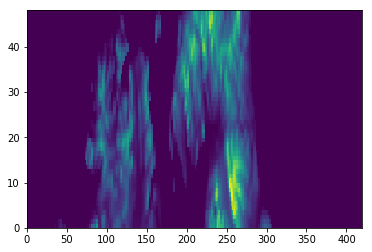

In [94]:
plt.pcolormesh(test['surface_altitude'].values.reshape(187, 48, 419)[0])

In [3]:
alt = iris.load('../netcdf/surface_altitude.nc')[0]

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [4]:
gradx, grady = alt.copy(), alt.copy()

gradx.data = np.gradient(alt.data)[1]
grady.data = np.gradient(alt.data)[0]

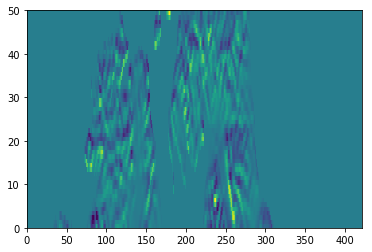

In [5]:
plt.pcolormesh(grady.data)

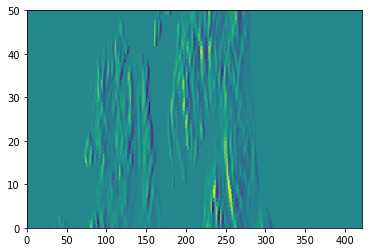

In [6]:
plt.pcolormesh(gradx.data)

In [7]:
slope = alt.copy()
slope.data = np.sqrt(np.square(gradx.data) + np.square(grady.data))

In [8]:
face = alt.copy()
face.data = np.arctan2(grady.data, gradx.data)

In [88]:
plt.pcolormesh(alt.data)

NameError: name 'alt' is not defined

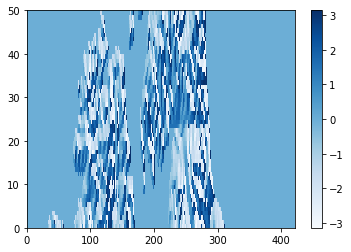

In [10]:
plt.pcolormesh(face.data, cmap='Blues')
plt.colorbar()

In [11]:
from iris import quickplot as qplt

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


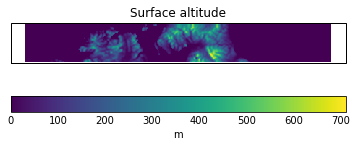

In [12]:
qplt.pcolormesh(alt, )

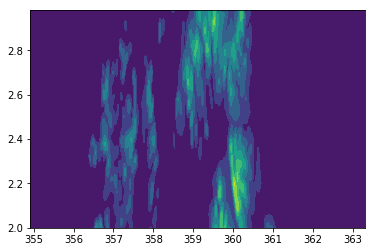

In [13]:
plt.contourf(alt.coord('grid_longitude').points, alt.coord('grid_latitude').points,  alt.data) 

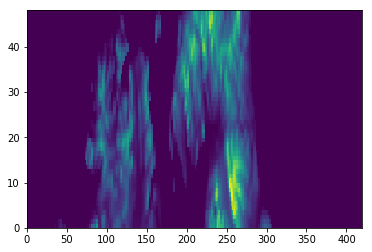

In [89]:
plt.pcolormesh(y['surface_altitude'][0])

In [14]:
c = alt.coord_system().as_cartopy_crs()

In [15]:
c.transform_points?

In [16]:
from sklearn.neighbors import NearestNeighbors
from itertools import product

ref = np.array(list(product(alt.coord('grid_longitude').points - 360, alt.coord('grid_latitude').points)))

coords = alt.coord_system().as_cartopy_crs().transform_points(ccrs.PlateCarree(), 
                                                              train['longitude'].values, 
                                                              train['latitude'].values)[:,:2]

nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(ref)

inds = nbrs.kneighbors(coords, return_distance=False).flatten()
inds2 = np.array([-(inds % alt.coord('grid_latitude').points.shape), 
                 inds // alt.coord('grid_latitude').points.shape]).T
# print(coords[:10])
# print(inds2[:10])
# print(alt[inds2[:10,0], inds2[:10,1]].coords())
alts = alt.data[inds2[:,0], inds2[:,1]]
slopes = slope.data[inds2[:,0], inds2[:,1]]
faces = face.data[inds2[:,0], inds2[:,1]]
print(coords)

[[-5.07928467  2.03004956]
 [-4.97927856  2.03004956]
 [-4.89926147  2.03004956]
 ..., 
 [ 2.90072632  2.97004962]
 [ 3.02072144  2.97004962]
 [ 3.14071655  2.97004962]]
CPU times: user 804 ms, sys: 12 ms, total: 816 ms
Wall time: 816 ms


In [17]:
alt

<iris 'Cube' of surface_altitude / (m) (grid_latitude: 50; grid_longitude: 421)>

In [18]:
train['longitude'].values.shape

(568870,)

In [23]:
train['alt'] = alts
train['slope'] = slopes
train['face'] = faces

In [24]:
train.groupby(['latitude', 'longitude'])
counts = train.groupby([pd.cut(train['latitude'], np.arange(54, 56, 0.01)), 
                          pd.cut(train['longitude'], np.arange(-12, 4, 0.1))]).mean()

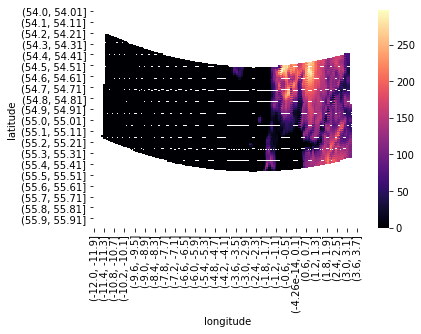

In [25]:
import seaborn as sns
sns.heatmap(counts['surface_altitude'].unstack(), cmap='magma')

In [30]:
counts

Unnamed: 0  DOY  air_temperature  distance  \
latitude       longitude                                                    
(54.0, 54.01]  (-12.0, -11.9]         NaN  NaN              NaN       NaN   
               (-11.9, -11.8]         NaN  NaN              NaN       NaN   
               (-11.8, -11.7]         NaN  NaN              NaN       NaN   
               (-11.7, -11.6]         NaN  NaN              NaN       NaN   
               (-11.6, -11.5]         NaN  NaN              NaN       NaN   
               (-11.5, -11.4]         NaN  NaN              NaN       NaN   
               (-11.4, -11.3]         NaN  NaN              NaN       NaN   
               (-11.3, -11.2]         NaN  NaN              NaN       NaN   
               (-11.2, -11.1]         NaN  NaN              NaN       NaN   
               (-11.1, -11.0]         NaN  NaN              NaN       NaN   
               (-11.0, -10.9]         NaN  NaN              NaN       NaN   
               (-10.9, -10.8]         NaN  NaN              NaN       NaN   
               (-10.8, -10.7]         NaN  NaN              NaN       NaN   
               (-10.7, -10.6]         NaN  NaN              NaN       NaN   
               (-10.6, -10.5]         NaN  NaN              NaN       NaN   
               (-10.5, -10.4]         NaN  NaN              NaN       NaN   
               (-10.4, -10.3]         NaN  NaN              NaN       NaN   
               (-10.3, -10.2]         NaN  NaN              NaN       NaN   
               (-10.2, -10.1]         NaN  NaN              NaN       NaN   
               (-10.1, -10.0]         NaN  NaN              NaN       NaN   
               (-10.0, -9.9]          NaN  NaN              NaN       NaN   
               (-9.9, -9.8]           NaN  NaN              NaN       NaN   
               (-9.8, -9.7]           NaN  NaN              NaN       NaN   
               (-9.7, -9.6]           NaN  NaN              NaN       NaN   
               (-9.6, -9.5]           NaN  NaN              NaN       NaN   
               (-9.5, -9.4]           NaN  NaN              NaN       NaN   
               (-9.4, -9.3]           NaN  NaN              NaN       NaN   
               (-9.3, -9.2]           NaN  NaN              NaN       NaN   
               (-9.2, -9.1]           NaN  NaN              NaN       NaN   
               (-9.1, -9.0]           NaN  NaN              NaN       NaN   
...                                   ...  ...              ...       ...   
(55.98, 55.99] (0.9, 1.0]             NaN  NaN              NaN       NaN   
               (1.0, 1.1]             NaN  NaN              NaN       NaN   
               (1.1, 1.2]             NaN  NaN              NaN       NaN   
               (1.2, 1.3]             NaN  NaN              NaN       NaN   
               (1.3, 1.4]             NaN  NaN              NaN       NaN   
               (1.4, 1.5]             NaN  NaN              NaN       NaN   
               (1.5, 1.6]             NaN  NaN              NaN       NaN   
               (1.6, 1.7]             NaN  NaN              NaN       NaN   
               (1.7, 1.8]             NaN  NaN              NaN       NaN   
               (1.8, 1.9]             NaN  NaN              NaN       NaN   
               (1.9, 2.0]             NaN  NaN              NaN       NaN   
               (2.0, 2.1]             NaN  NaN              NaN       NaN   
               (2.1, 2.2]             NaN  NaN              NaN       NaN   
               (2.2, 2.3]             NaN  NaN              NaN       NaN   
               (2.3, 2.4]             NaN  NaN              NaN       NaN   
               (2.4, 2.5]             NaN  NaN              NaN       NaN   
               (2.5, 2.6]             NaN  NaN              NaN       NaN   
               (2.6, 2.7]             NaN  NaN              NaN       NaN   
               (2.7, 2.8]             NaN  NaN              NaN       NaN   
               (2.8, 2.9]  

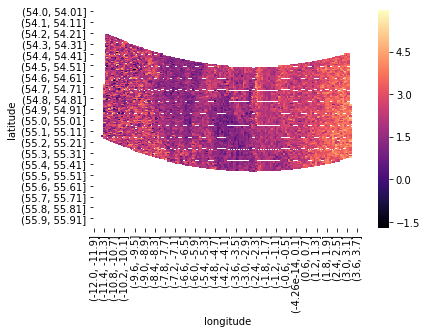

In [36]:
sns.heatmap(counts['x_wind'].unstack(), cmap='magma')

In [ ]:
sns.heatmap(counts['alt'].unstack(), cmap='magma')

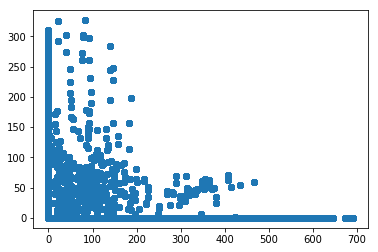

In [323]:
plt.scatter(alts, train['surface_altitude'].values)

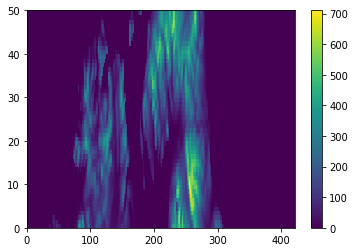

In [322]:
plt.pcolormesh(alt.data)
plt.colorbar()

In [206]:
alt.coord('grid_latitude').points, alt.coord('grid_longitude').points - 360

(array([ 2.00004983,  2.02004981,  2.04004979,  2.06004977,  2.08004975,
         2.10004973,  2.12005019,  2.14005017,  2.16005015,  2.18005013,
         2.20005012,  2.2200501 ,  2.24005008,  2.26005006,  2.28005004,
         2.30005002,  2.32005   ,  2.34004998,  2.36004996,  2.38004994,
         2.40004992,  2.42004991,  2.44004989,  2.46004987,  2.48004985,
         2.50004983,  2.52004981,  2.54004979,  2.56004977,  2.58004975,
         2.60004973,  2.62004972,  2.64005017,  2.66005015,  2.68005013,
         2.70005012,  2.7200501 ,  2.74005008,  2.76005006,  2.78005004,
         2.80005002,  2.82005   ,  2.84004998,  2.86004996,  2.88004994,
         2.90004992,  2.92004991,  2.94004989,  2.96004987,  2.98004985], dtype=float32),
 array([-5.08926392, -5.0692749 , -5.04925537, -5.02926636, -5.00927734,
        -4.98925781, -4.9692688 , -4.94924927, -4.92926025, -4.90927124,
        -4.88925171, -4.8692627 , -4.84927368, -4.82925415, -4.80926514,
        -4.78927612, -4.76925659, 

In [180]:
print(coords[165789])

[ 3.2807312   2.03004956]


In [166]:
train[['latitude', 'longitude']].values

array([[ 54.22378023, -11.2047942 ],
       [ 54.23567166, -11.03503002],
       [ 54.2450188 , -10.89912898],
       ..., 
       [ 55.36757201,   2.601837  ],
       [ 55.35893236,   2.81212573],
       [ 55.34994489,   3.02232251]])

In [116]:
pt.data

array(0.0, dtype=float32)

In [49]:
alt.extract(iris.Constraint(grid_latitude=lambda x: 2 < x < 2.5, 
                            grid_longitude=lambda x: -4 + 360 < x < -3 + 360))

<iris 'Cube' of surface_altitude / (m) (grid_latitude: 25; grid_longitude: 50)>

In [129]:
train[['latitude', 'longitude']].values

array([[ 54.22378023, -11.2047942 ],
       [ 54.23567166, -11.03503002],
       [ 54.2450188 , -10.89912898],
       ..., 
       [ 55.36757201,   2.601837  ],
       [ 55.35893236,   2.81212573],
       [ 55.34994489,   3.02232251]])